# **Metode K-Mean**


## **Pengertian Metode K-Mean**

K-Means adalah metode clustering atau pengelompokan data yang termasuk dalam jenis unsupervised learning. Metode ini bertujuan untuk membagi sekumpulan data ke dalam beberapa kelompok (cluster) berdasarkan kesamaan karakteristik

Untuk melakukan pengelompokkan data ada beberapa cara/metode yang dapat digunakan seperti salah satunya yaitu clustering. Metode Clustering dapat
digunakan untuk mengelompokkan suatu data yang memiliki kesamaan antara satu data dengan data yang lainnya.

## **Manfaat *Claustering***

Manfaat clustering antara lain adalah mengelompokkan data berdasarkan kesamaan tertentu sehingga memudahkan analisis dan pengambilan keputusan, mengidentifikasi pola tersembunyi dalam dataset yang besar, mengoptimalkan segmentasi pasar untuk strategi pemasaran yang lebih efektif, meningkatkan deteksi anomali atau penyimpangan dalam data, mempercepat proses pengolahan data melalui pengelompokan awal, memudahkan visualisasi data yang kompleks, serta membantu dalam pengembangan sistem rekomendasi berbasis kesamaan karakteristik.

## **Inertia (Sum Square error/SSE)**

Inertia, dalam konteks algoritma K-Means clustering, adalah metrik yang digunakan untuk mengukur seberapa baik klaster-klaster terbentuk dengan cara mengukur jarak total antara titik data dengan pusat klaster (centroid). Semakin rendah nilai inertia, semakin baik hasil clustering karena titik data lebih dekat ke centroid klaster mereka.
# Definisi Inertia:

$$
\text{Inertia} = \sum_{i=1}^{n} \left\| x_i - \mu_{c_i} \right\|^2
$$

**Penjelasan**
- $x_i$: Titik data ke-$i$
- $\mu_{c_i}$: Centroid dari klaster tempat $x_i$ berada
- $\left\| x_i - \mu_{c_i} \right\|^2$: Jarak Euclidean kuadrat antara $x_i$ dan centroid-nya
- $n$: Jumlah total data

Dengan kata lain, inertia mengukur total jarak kuadrat antara titik data dengan pusat klaster mereka.

## **Silhouette Analysis**

Silhouette Analysis adalah metode untuk menilai kualitas clustering dengan mengukur seberapa mirip objek dalam suatu cluster dan seberapa berbeda objek tersebut dari objek di cluster lain. Nilai Silhouette berkisar antara -1 hingga 1

Rumus Silhouette Score dinyatakan sebagai:
$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

Keterangan:

- $a(i)$: Rata-rata jarak dari titik $i$ ke semua titik lain dalam klaster yang sama (cohesion)
- $b(i)$: Rata-rata jarak dari titik $i$ ke semua titik dalam klaster terdekat yang bukan miliknya (separation)
- $s(i)$: Skor silhouette untuk titik $i$, dengan nilai antara -1 dan 1

Nilai skor $s(i)$ ditafsirkan sebagai berikut:
- Jika $s(i) \approx 1$, maka titik berada jauh dari klaster lain dan cocok dengan klasternya
- Jika $s(i) \approx 0$, maka titik berada di antara dua klaster
- Jika $s(i) \approx -1$, maka titik bisa jadi salah masuk klaster

Nilai Silhouette Score keseluruhan adalah rata-rata nilai
𝑆
(
𝑖
)
S(i) untuk semua objek dalam dataset

## **Implementasi dengan menggunakan data Iris**

In [ ]:
%pip install pymysql
%pip install psycopg2

Kode dibawah  terhubung ke dua basis data berbeda (PostgreSQL dan MySQL), mengambil data dari masing-masing basis data, menggabungkan kumpulan data berdasarkan kolom umum (id dan kelas), lalu mencetak kumpulan data yang digabungkan.

In [ ]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_pg_data():
    conn = psycopg2.connect(
        host="pg-3d261dbe-sifa-190.i.aivencloud.com",
        user="avnadmin",
        password="AVNS_dFoBwFz1ZSfQpVx7DRi",
        database="defaultdb",
        port=15434
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM iris_postgresql")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-201e3cbe-sifa-190.i.aivencloud.com",
        user="avnadmin",
        password="AVNS_LZy909DRs0jlZfh2C0Q",
        database="defaultdb",
        port=15434
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM irismysql")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id' dan 'Class'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Cetak semua data hasil gabungan tanpa indeks
print(df_merged.to_string(index=False))

## **Clauster data menggunakan metode k means dengan claster 2,3,4**

Kode dibawah bertujuan untuk melakukan K-Means clustering dan mengevaluasi hasil clustering menggunakan Adjusted Rand Score (ARS), yang mengukur kesesuaian hasil clustering dengan label ground truth.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import adjusted_rand_score

# 1. Pastikan kolom 'class' ada dan ubah ke angka sebagai ground truth
if 'class' in df_merged.columns:
    le = LabelEncoder()
    df_merged['class_encoded'] = le.fit_transform(df_merged['class'])  # label ground truth numerik
    y = df_merged['class_encoded']
else:
    raise ValueError("Kolom 'class' tidak ditemukan di df_merged!")

# 2. Ambil fitur numerik dan buang kolom yang tidak diperlukan
columns_to_exclude = ['id', 'class', 'class_encoded', 'jenis']
available_columns_to_drop = [col for col in columns_to_exclude if col in df_merged.columns]

# Ambil hanya kolom numerik untuk fitur (selain label dan non-feature)
X = df_merged.drop(columns=available_columns_to_drop)
X = X.select_dtypes(include=[int, float])

if X.shape[1] == 0:
    raise ValueError("Tidak ada kolom numerik yang bisa digunakan untuk clustering!")

# 3. Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Fungsi untuk menjalankan K-Means dan mengevaluasi akurasi
def perform_kmeans(X_scaled, y, k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    centroids = kmeans.cluster_centers_
    accuracy = adjusted_rand_score(y, labels)

    print(f"\nHasil K-Means dengan {k} Klaster:")
    print("Centroids:")
    print(centroids)
    print(f"Akurasi (Adjusted Rand Score): {accuracy:.3f}")

    return labels, centroids, accuracy

# 5. Jalankan untuk k = 2, 3, 4
for k in [2, 3, 4]:
    perform_kmeans(X_scaled, y, k)



Hasil K-Means dengan 2 Klaster:
Centroids:
[[-3.53868320e-02 -1.71297146e-03 -7.87218273e-02 -8.03772869e-02]
 [ 5.27263797e+00  2.55232748e-01  1.17295523e+01  1.19762157e+01]]
Akurasi (Adjusted Rand Score): 0.000

Hasil K-Means dengan 3 Klaster:
Centroids:
[[ 4.27605786  1.90991963 -0.08197772 -0.24788252]
 [-0.18508977 -0.0680891  -0.07860878 -0.07456113]
 [ 5.27263797  0.25523275 11.72955227 11.97621574]]
Akurasi (Adjusted Rand Score): 0.001

Hasil K-Means dengan 4 Klaster:
Centroids:
[[-1.85089773e-01 -6.80891034e-02 -7.86087754e-02 -7.45611330e-02]
 [ 5.27263797e+00  2.55232748e-01  1.17295523e+01  1.19762157e+01]
 [ 5.09033673e+00 -1.09771711e-01 -2.80745626e-03 -2.94863864e-01]
 [ 1.01894239e+00  9.98868498e+00 -3.98658789e-01 -5.99571438e-02]]
Akurasi (Adjusted Rand Score): 0.002


## **Visualisasi hasil Claustering**

Kode di bawah bertujuan untuk melakukan clustering menggunakan K-Means, mengukur kualitas clustering menggunakan Adjusted Rand Score (ARS), dan memvisualisasikan hasil clustering dalam 2D menggunakan PCA.

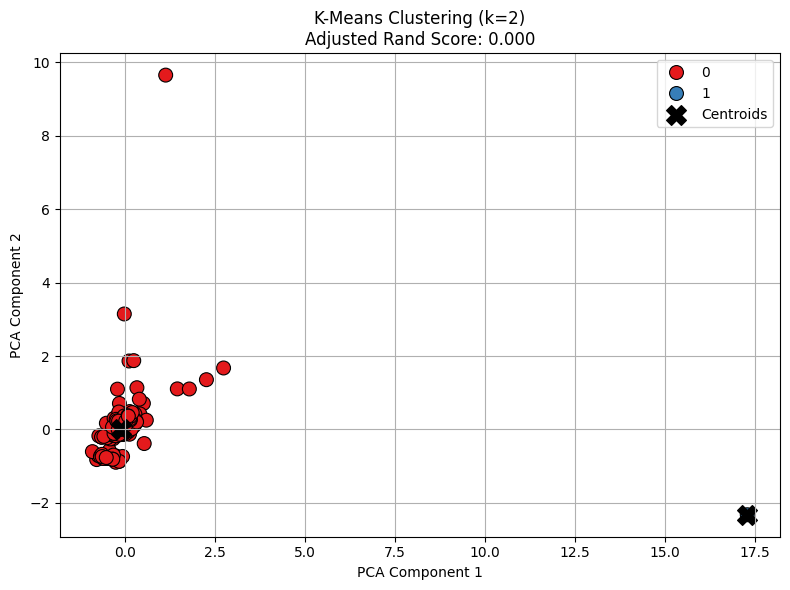

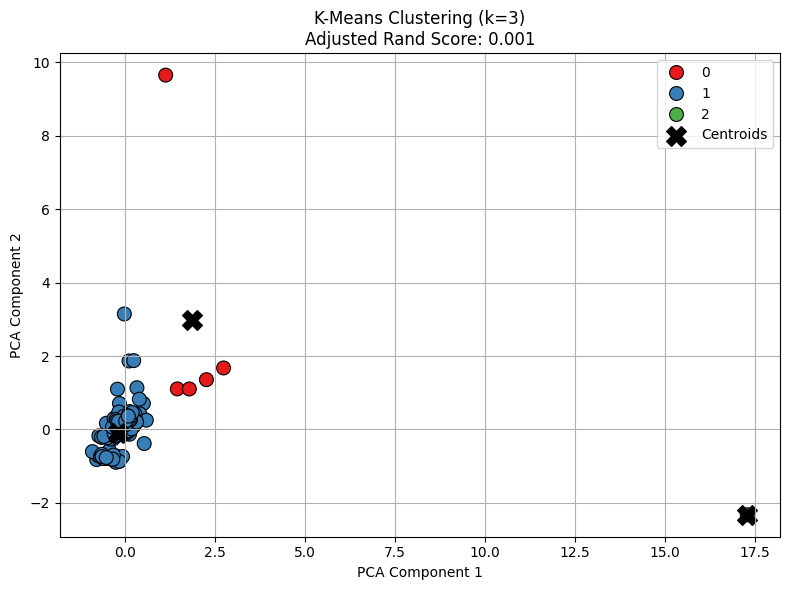

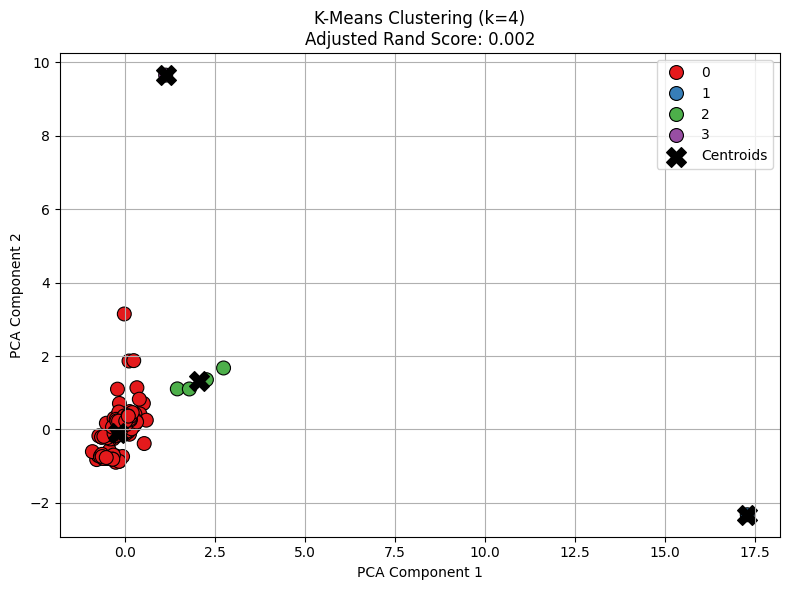

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Encode label ground truth
if 'class' in df_merged.columns:
    le = LabelEncoder()
    df_merged['class_encoded'] = le.fit_transform(df_merged['class'])
    y = df_merged['class_encoded']
else:
    raise ValueError("Kolom 'class' tidak ditemukan di df_merged!")

# 2. Ambil hanya fitur numerik
columns_to_exclude = ['id', 'class', 'class_encoded', 'jenis']
available_columns_to_drop = [col for col in columns_to_exclude if col in df_merged.columns]
X = df_merged.drop(columns=available_columns_to_drop)
X = X.select_dtypes(include=[int, float])

if X.shape[1] == 0:
    raise ValueError("Tidak ada kolom numerik yang bisa digunakan untuk clustering!")

# 3. Standarisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. PCA untuk reduksi dimensi ke 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 5. Fungsi KMeans + visualisasi
def perform_kmeans_plot(X_scaled, X_pca, y, k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    centroids_2d = pca.transform(kmeans.cluster_centers_)
    accuracy = adjusted_rand_score(y, labels)

    # Plot hasil klaster
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1', s=100, edgecolor='k', legend='full')
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='black', marker='X', s=200, label='Centroids')
    plt.title(f"K-Means Clustering (k={k})\nAdjusted Rand Score: {accuracy:.3f}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return labels, accuracy

# 6. Jalankan dan visualisasikan untuk k = 2, 3, 4
for k in [2, 3, 4]:
    perform_kmeans_plot(X_scaled, X_pca, y, k)


## **Menghitung Inertia**

Kode di bawah bertujuan untuk mengimplementasikan perhitungan Inertia secara manual dan membandingkannya dengan hasil perhitungan inertia dari library sklearn pada model K-Means.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Fungsi untuk menghitung inertia secara manual
def calculate_inertia_step_by_step(X_scaled, labels, centroids):
    inertia = 0
    print("Langkah-langkah perhitungan Inertia:")

    # Hitung jarak kuadrat dari tiap data point ke centroid-nya
    for i in range(len(X_scaled)):
        cluster = labels[i]
        distance = np.linalg.norm(X_scaled[i] - centroids[cluster]) ** 2  # Jarak kuadrat
        inertia += distance  # Tambahkan ke total inertia
        print(f"Titik data {i+1} (Fitur: {X_scaled[i]}), Klaster: {cluster}, "
              f"Centroid: {centroids[cluster]}, Jarak kuadrat: {distance:.3f}, "
              f"Inertia sementara: {inertia:.3f}")

    return inertia

# 3. Fungsi untuk menjalankan KMeans dan menghitung inertia manual
def perform_kmeans(X_scaled, y, k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)  # Prediksi label untuk data
    centroids = kmeans.cluster_centers_   # Ambil posisi centroid

    print(f"\n=== Hasil K-Means dengan {k} Klaster ===")
    print(f"Centroids (fitur hasil standarisasi):\n{centroids}")

    # Hitung inertia manual
    manual_inertia = calculate_inertia_step_by_step(X_scaled, labels, centroids)
    print(f"\nTotal Inertia Manual: {manual_inertia:.3f}")

    # Bandingkan dengan inertia dari sklearn
    sklearn_inertia = kmeans.inertia_
    print(f"Inertia dari sklearn: {sklearn_inertia:.3f}")
    print("="*50)

    return labels, centroids, manual_inertia

# 4. Jalankan untuk k = 2, 3, dan 4
for k in [2, 3, 4]:
    perform_kmeans(X_scaled, y, k)



=== Hasil K-Means dengan 2 Klaster ===
Centroids (fitur hasil standarisasi):
[[-3.53868320e-02 -1.71297146e-03 -7.87218273e-02 -8.03772869e-02]
 [ 5.27263797e+00  2.55232748e-01  1.17295523e+01  1.19762157e+01]]
Langkah-langkah perhitungan Inertia:
Titik data 1 (Fitur: [-0.51238802 -0.71811248 -0.33127984  0.1190194 ]), Klaster: 0, Centroid: [-0.03538683 -0.00171297 -0.07872183 -0.08037729], Jarak kuadrat: 0.844, Inertia sementara: 0.844
Titik data 2 (Fitur: [ 5.27263797  0.25523275 11.72955227 11.97621574]), Klaster: 1, Centroid: [ 5.27263797  0.25523275 11.72955227 11.97621574], Jarak kuadrat: 0.000, Inertia sementara: 0.844
Titik data 3 (Fitur: [-0.52454143 -0.71811248 -0.46603774 -0.01521301]), Klaster: 0, Centroid: [-0.03538683 -0.00171297 -0.07872183 -0.08037729], Jarak kuadrat: 0.907, Inertia sementara: 1.751
Titik data 4 (Fitur: [-0.5002346  -0.71811248 -0.49972721 -0.05995714]), Klaster: 0, Centroid: [-0.03538683 -0.00171297 -0.07872183 -0.08037729], Jarak kuadrat: 0.907, Ine

## **Visualisasi Menggunakan Metode Elbow**

Kode di bawah bertujuan untuk menentukan jumlah klaster optimal menggunakan Metode Elbow berdasarkan Inertia (Sum of Squared Distances)

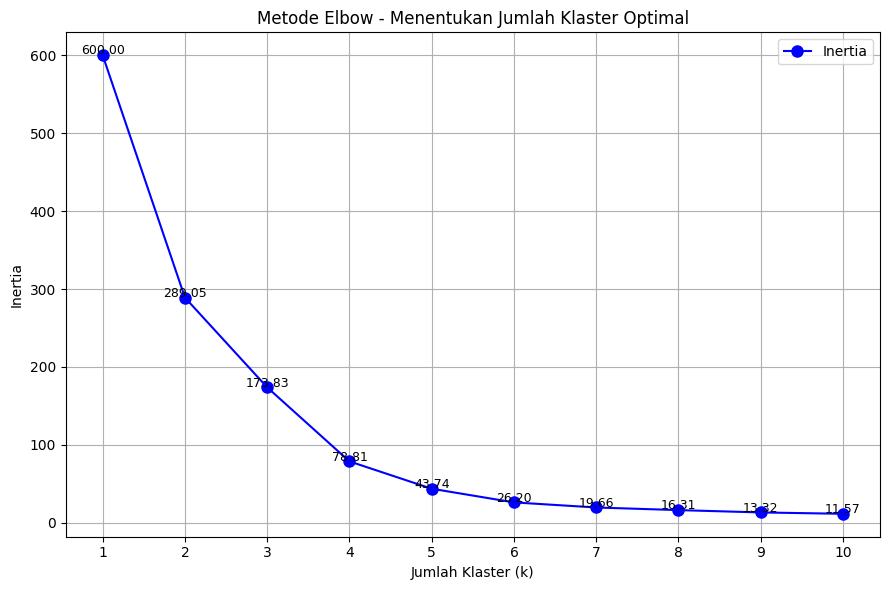

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Hitung inertia untuk berbagai nilai k
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# 3. Plot Elbow Diagram
plt.figure(figsize=(9, 6))
plt.plot(K_range, inertias, 'bo-', markersize=8, label='Inertia')
plt.title("Metode Elbow - Menentukan Jumlah Klaster Optimal")
plt.xlabel("Jumlah Klaster (k)")
plt.ylabel("Inertia")
plt.xticks(K_range)
plt.grid(True)

# Tambahkan label inertia di tiap titik
for i, inertia in enumerate(inertias):
    plt.text(K_range[i], inertias[i] + 1, f"{inertia:.2f}", ha='center', fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()


## **Menghitung Silhouette**

Kode di dibawah bertujuan untuk melakukan Clustering menggunakan K-Means dan mengevaluasi hasil clustering menggunakan Silhouette Score


=== Hasil K-Means dengan 2 Klaster ===
Centroids:
[[-3.53868320e-02 -1.71297146e-03 -7.87218273e-02 -8.03772869e-02]
 [ 5.27263797e+00  2.55232748e-01  1.17295523e+01  1.19762157e+01]]
Silhouette Score untuk 2 klaster: 0.926

=== Hasil K-Means dengan 3 Klaster ===
Centroids:
[[ 4.27605786  1.90991963 -0.08197772 -0.24788252]
 [-0.18508977 -0.0680891  -0.07860878 -0.07456113]
 [ 5.27263797  0.25523275 11.72955227 11.97621574]]
Silhouette Score untuk 3 klaster: 0.839

=== Hasil K-Means dengan 4 Klaster ===
Centroids:
[[-1.85089773e-01 -6.80891034e-02 -7.86087754e-02 -7.45611330e-02]
 [ 5.27263797e+00  2.55232748e-01  1.17295523e+01  1.19762157e+01]
 [ 5.09033673e+00 -1.09771711e-01 -2.80745626e-03 -2.94863864e-01]
 [ 1.01894239e+00  9.98868498e+00 -3.98658789e-01 -5.99571438e-02]]
Silhouette Score untuk 4 klaster: 0.829


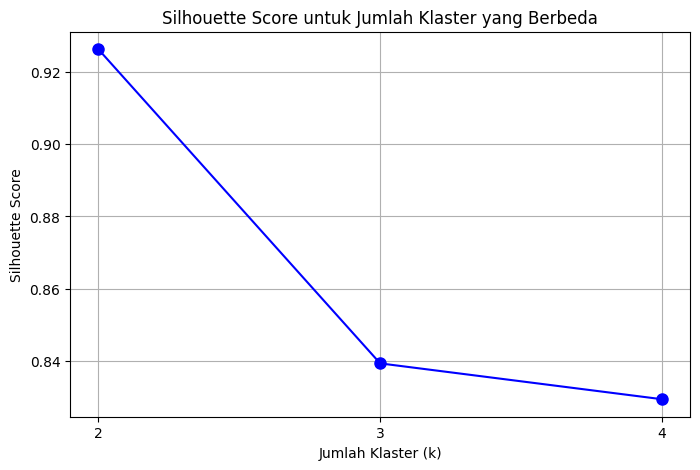

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# --- Asumsi: df_merged sudah didefinisikan sebelumnya dari merge data PostgreSQL & MySQL ---

# 1. Ambil hanya fitur numerik (hindari kolom non-feature)
columns_to_exclude = ['id', 'class', 'class_encoded', 'jenis']
available_columns_to_drop = [col for col in columns_to_exclude if col in df_merged.columns]

X = df_merged.drop(columns=available_columns_to_drop)
X = X.select_dtypes(include=[int, float])

if X.shape[1] == 0:
    raise ValueError("Tidak ada kolom numerik yang tersedia untuk clustering.")

# 2. Standarisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Fungsi untuk K-Means dan Silhouette Score
def perform_kmeans_with_silhouette(X_scaled, k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X_scaled, labels)
    centroids = kmeans.cluster_centers_

    print(f"\n=== Hasil K-Means dengan {k} Klaster ===")
    print(f"Centroids:\n{centroids}")
    print(f"Silhouette Score untuk {k} klaster: {silhouette_avg:.3f}")

    return silhouette_avg

# 4. Jalankan dan simpan hasil silhouette score
silhouette_scores = []
for k in [2, 3, 4]:
    silhouette_score_k = perform_kmeans_with_silhouette(X_scaled, k)
    silhouette_scores.append(silhouette_score_k)

# 5. Visualisasi hasil silhouette
plt.figure(figsize=(8, 5))
plt.plot([2, 3, 4], silhouette_scores, 'bo-', markersize=8)
plt.title("Silhouette Score untuk Jumlah Klaster yang Berbeda")
plt.xlabel("Jumlah Klaster (k)")
plt.ylabel("Silhouette Score")
plt.xticks([2, 3, 4])
plt.grid(True)
plt.show()
